In [40]:
import pickle
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
FICHERO_DATA = 'data/data_reviews.csv'
FICHERO_DATA_VALIDATION = 'data/data_validation.csv'

In [42]:
# Importamos el csv
df_entreno = pd.read_csv(FICHERO_DATA)
df_entreno.head()

,reseñas,IA,longitud,longitud_promedio,palabras_unicas,signos_de_puntuación,frecuencia_pronombres,variedad_lexica,entropia_lexica,expresiones,tfidf,palabras_complejas,tecnicismos,polaridad,subjetividad,coherencia
0,Necesitaba un nuevo movil y me decidí por este...,0,297,4.066667,0.733333,6,0,0.733333,5.267482,0,5.640761e-02,3,0,0.0,0.0,0.920000
1,Está en perfectas condiciones la batería al 10...,0,99,5.375000,1.000000,2,0,1.000000,4.000000,0,5.551115e-17,2,0,0.0,0.0,1.000000
2,Me llegó ayer el iPhone en perfectas condicion...,0,436,4.402439,0.695122,7,0,0.707317,5.710972,0,5.749596e-02,5,0,0.0,0.0,0.857143
3,Compré un iPhone 12 a este vendedor y hace un...,0,657,4.124031,0.581395,10,1,0.604651,5.880116,0,7.866846e-02,5,0,0.0,0.0,0.823529
4,Soy usuario de IPhone desde el principio. Teng...,0,596,4.109244,0.638655,11,0,0.655462,5.953860,0,7.357145e-02,4,0,0.0,0.0,0.953488


In [43]:
# Cargar el modelo desde HDF5
model = load_model('data/modelo_LSTM.h5')

# Cargar los datos preprocesados desde el archivo pickle
with open('data/datos_preprocesados.pkl', 'rb') as file:
    data = pickle.load(file)
    X_test_numerical_scaled = data['X_test_numerical_scaled']
    X_test_text_padded = data['X_test_text_padded']
    y_test = data['y_test']
    scaler = data['scaler']
    tokenizer = data['tokenizer']
    max_length = data['max_length']

c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [44]:
# Evaluar el modelo
loss, accuracy = model.evaluate([X_test_numerical_scaled, X_test_text_padded], y_test)
print(f'Pérdida en el conjunto de prueba: {loss}')
print(f'Precisión en el conjunto de prueba: {accuracy}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7595 - loss: 0.4589
Pérdida en el conjunto de prueba: 0.4447157680988312
Precisión en el conjunto de prueba: 0.783561646938324


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
y_test shape: (730,)
y_pred_classes shape: (730,)
y_test unique values: [0 1]
y_pred_classes unique values: [0 1]


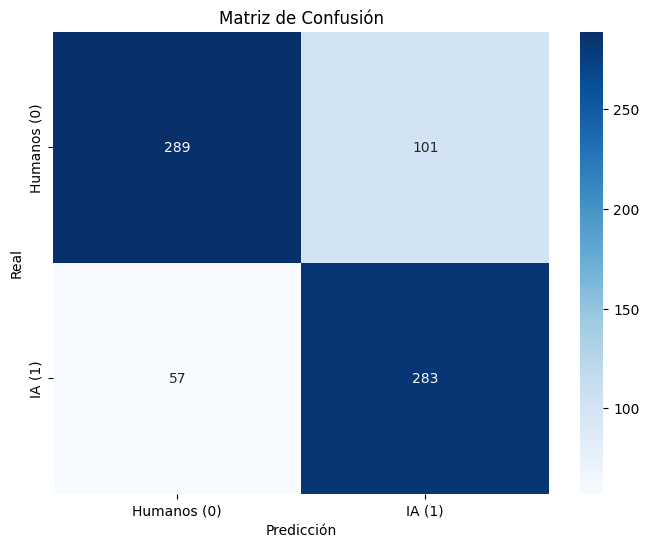

In [45]:
# Obtener probabilidades de las predicciones
y_prob = model.predict([X_test_numerical_scaled, X_test_text_padded])
# Convertir probabilidades en clases binarias
y_pred_classes = (y_prob > 0.5).astype(int).flatten()

# Convertir "y_test" a un array NumPy si no lo es ya
if not isinstance(y_test, np.ndarray):
    y_test = np.array(y_test).flatten()

# Asegurarse de que "y_pred_classes" sea un array NumPy
if not isinstance(y_pred_classes, np.ndarray):
    y_pred_classes = np.array(y_pred_classes).flatten()

# Verificar dimensiones y valores únicos
print(f'y_test shape: {y_test.shape}')
print(f'y_pred_classes shape: {y_pred_classes.shape}')
print(f'y_test unique values: {np.unique(y_test)}')
print(f'y_pred_classes unique values: {np.unique(y_pred_classes)}')

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Humanos (0)', 'IA (1)'], 
            yticklabels=['Humanos (0)', 'IA (1)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [46]:
# Obtener el reporte de clasificación
report = classification_report(y_test, y_pred_classes, target_names=['Humano', 'IA'])
print(report)

              precision    recall  f1-score   support

      Humano       0.84      0.74      0.79       390
          IA       0.74      0.83      0.78       340

    accuracy                           0.78       730
   macro avg       0.79      0.79      0.78       730
weighted avg       0.79      0.78      0.78       730



In [47]:
# Obtener las probabilidades de cada reseña
probabilities = model.predict([X_test_numerical_scaled, X_test_text_padded])

# Mostrar las probabilidades y clasificaciones finales
for i in range(len(probabilities)):
    prob_ia = probabilities[i][0]  # Probabilidad de que la reseña sea escrita por IA
    prob_humano = 1 - prob_ia  # Probabilidad de que la reseña sea escrita por un humano
    
    print(f'Reseña {i + 1}: {prob_ia * 100:.2f}% probabilidad de ser IA, {prob_humano * 100:.2f}% probabilidad de ser humano')

# Opcional: establecer un umbral si quieres categorizar basado en la probabilidad
threshold = 0.5
predicciones = ['IA' if prob > threshold else 'Humano' for prob in probabilities]

# Mostrar las predicciones categorizadas
for i, pred in enumerate(predicciones):
    print(f'Reseña {i + 1} fue clasificada como: {pred}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Reseña 1: 0.24% probabilidad de ser IA, 99.76% probabilidad de ser humano
Reseña 2: 64.59% probabilidad de ser IA, 35.41% probabilidad de ser humano
Reseña 3: 84.47% probabilidad de ser IA, 15.53% probabilidad de ser humano
Reseña 4: 85.03% probabilidad de ser IA, 14.97% probabilidad de ser humano
Reseña 5: 55.20% probabilidad de ser IA, 44.80% probabilidad de ser humano
Reseña 6: 66.06% probabilidad de ser IA, 33.94% probabilidad de ser humano
Reseña 7: 41.84% probabilidad de ser IA, 58.16% probabilidad de ser humano
Reseña 8: 61.97% probabilidad de ser IA, 38.03% probabilidad de ser humano
Reseña 9: 10.03% probabilidad de ser IA, 89.97% probabilidad de ser humano
Reseña 10: 45.34% probabilidad de ser IA, 54.66% probabilidad de ser humano
Reseña 11: 57.38% probabilidad de ser IA, 42.62% probabilidad de ser humano
Reseña 12: 54.97% probabilidad de ser IA, 45.03% probabilidad de ser humano
Reseña 13: 68.39% probabilidad de ser IA, 31.61% probabili

In [48]:
# Probemos el modelo con datos no utilizados ni en el test ni en el train
validation_data = pd.read_csv(FICHERO_DATA_VALIDATION)
validation_data.head()

,reseñas,IA,longitud,longitud_promedio,palabras_unicas,signos_de_puntuación,frecuencia_pronombres,variedad_lexica,entropia_lexica,tfidf,palabras_complejas,tecnicismos,polaridad,subjetividad,coherencia
0,Después de probar un par de otras marcas de ga...,0,518,4.174757,0.660194,11,0,0.679612,5.822484,0.086815,2,0,0.0,0.0,0.897436
1,Mi gato ama estas golosinas. Si alguna vez no ...,0,543,4.045455,0.681818,11,2,0.718182,6.077488,0.059901,3,0,0.0,1.0,0.888889
2,Un poco menos de lo que esperaba. Tiende a ten...,0,139,3.612903,0.741935,3,0,0.774194,4.438067,0.105941,0,0,0.0,0.0,0.900000
3,Y quiero felicitar al artista gráfico por habe...,0,634,4.182540,0.706349,18,0,0.738095,6.230938,0.046925,2,0,0.0,0.0,0.967742
4,"Por favor, añada más sabor a piña a sus paquet...",0,118,3.730769,0.730769,4,0,0.807692,4.286790,0.085105,1,0,0.0,0.0,0.818182


In [49]:
# El max_length, el tokenizer y el scaler deben ser los mismos que en el entrenamiento y los datasets deben tener la misma estructura.

In [50]:
X_text_validation = validation_data['reseñas']
X_numerical_validation = validation_data.drop(columns=['reseñas', 'IA'])  # Excluir la columna de texto y la de etiquetas

# 2. Escalar las características numéricas usando el mismo scaler
X_numerical_validation_scaled = scaler.transform(X_numerical_validation)

# 3. Tokenizar y paddear el texto usando el mismo tokenizer y max_length
X_text_validation_seq = tokenizer.texts_to_sequences(X_text_validation)
X_text_validation_padded = pad_sequences(X_text_validation_seq, maxlen=max_length, padding='post')

In [51]:
# 4. Realizar predicciones
predicciones = model.predict([X_numerical_validation_scaled, X_text_validation_padded])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [52]:
# 5. Mostrar las predicciones
for i, pred in enumerate(predicciones):
    print(f"Reseña: {X_text_validation.iloc[i]}")
    print(f"Predicción (probabilidad): {pred[0]}")
    print()

Reseña: Después de probar un par de otras marcas de galletas de sándwich sin gluten, estas son las mejores de todas. Son crujientes y fieles a la textura de las otras galletas "reales" que no son sin gluten. Algunos pueden pensar que el relleno las hace un poco demasiado dulces, ¡pero para mí eso solo significa que he satisfecho mi antojo de dulce más pronto! La versión de chocolate de Glutino es igual de buena y tiene un verdadero sabor "chocolatoso" - algo que no se encuentra en las otras marcas sin gluten disponibles.
Predicción (probabilidad): 0.09867344796657562

Reseña: Mi gato ama estas golosinas. Si alguna vez no puedo encontrarla en la casa, solo abro la tapa y ella sale corriendo de donde sea que estuviera escondida para venir a buscar una golosina. No le gustan mucho las golosinas crujientes, así que estas son perfectas para ella. Le he dado los tres sabores y parece que le gustan a todos por igual. Sin embargo, tienden a secarse para cuando llego al final del frasco. La tap

In [53]:
# Si tienes las etiquetas verdaderas en el nuevo dataset y deseas evaluar el rendimiento:
if 'IA' in validation_data.columns:  # Suponiendo que la columna de etiquetas es 'IA'
    y_validation = validation_data['IA']
    loss, accuracy = model.evaluate([X_numerical_validation_scaled, X_text_validation_padded], y_validation)
    print(f'Accuracy en nuevo conjunto de datos: {accuracy}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8174 - loss: 0.3999
Accuracy en nuevo conjunto de datos: 0.8061224222183228


In [55]:
y_pred_validation = (predicciones > 0.5).astype(int)  # Convertir las probabilidades a clases binarias
y_validation = validation_data['IA']

print(classification_report(y_validation, y_pred_validation, target_names=['Humano (0)', 'IA (1)']))

              precision    recall  f1-score   support

  Humano (0)       0.82      0.79      0.80       147
      IA (1)       0.80      0.82      0.81       147

    accuracy                           0.81       294
   macro avg       0.81      0.81      0.81       294
weighted avg       0.81      0.81      0.81       294

